# E2E Eval Notebook
This notebook takes as input: 1) dataset, 2) request rate, and 3) GPU Max tput profiling, and gives as output the GPU selection across all solver policies. 

The output is used to set up the online load-balancing evals to confirm SLO attainment.

## Extract request size distribution from dataset

In [2]:
from datasets import load_dataset
import numpy as np
from transformers import LlamaTokenizer

tokenizer = LlamaTokenizer.from_pretrained('hf-internal-testing/llama-tokenizer')

def get_dataset(dataset_name):
  dataset = load_dataset(dataset_name)
  print(f'Dataset size: {len(dataset["train"])}')
  return dataset

/home/tylergriggs/miniconda3/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
None of PyTorch, TensorFlow >= 2.0, or Flax have been found. Models won't be available and only tokenizers, configuration and file/data utilities can be used.
You are using the default legacy behaviour of the <class 'transformers.models.llama.tokenization_llama.LlamaTokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565


In [15]:
from IPython.display import clear_output

def get_token_dataset(dataset):

  # Get token lengths of conversations 
  # [(from, token length), ...]
  token_dataset = []

  num_convos = 10000

  print('Computing token lengths of {dataset_name}')
  for i in range(num_convos):
  # for i in range(len(dataset['train'])):
    conversation = dataset['train'][i]['conversation']
    if i % 100 == 0:
      clear_output(wait=True)
      print(f'Progress: {round(100 * i / num_convos, 2)}%')
    token_dataset.append([])
    for j in range(len(conversation)):
      chat = conversation[j]
      token_dataset[i].append((chat['role'], len(tokenizer(chat['content']).input_ids)))
  return token_dataset

In [16]:
# Build list of input and output lenghths of LLM requests

def get_chat_lens(token_dataset):

  inlens = []
  outlens = []

  for convo in token_dataset:
    convo_token_total = 0
    for i in range(len(convo)):
      author, chat_tokens = convo[i]
      convo_token_total += chat_tokens
      if author == 'user' and i + 1 < len(convo) and convo[i+1][0] == 'assistant':
        inlens.append(convo_token_total)
        outlens.append(convo[i+1][1])
  print(f'Num chats: {len(inlens)}')
  return inlens, outlens

In [17]:
def print_distribution(inlens, outlens):
  print(f'Inlen distribution:')
  print('50p:', np.percentile(inlens, 50))
  print('90p:', np.percentile(inlens, 90))
  print('99p:', np.percentile(inlens, 99))
  print(f'Max: {max(inlens)}')
  print(f'Outlen distribution:')
  print('50p:', np.percentile(outlens, 50))
  print('90p:', np.percentile(outlens, 90))
  print('99p:', np.percentile(outlens, 99))
  print(f'Max: {max(outlens)}')

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

def display_distribution(inlens, outlens):

  regions = [0, 25, 100, 250, 500, 1000, 2000]
  regions_txt = ['25', '100', '250', '500', '1000', '2000']

  histogram, _, _ = np.histogram2d(inlens, outlens, bins=(regions, regions))


  num_datapoints = sum([sum(x) for x in histogram])
  histogram = histogram.T
  histogram = histogram[::-1]
  for i in range(len(histogram)):
    for j in range(len(histogram[i])):
      histogram[i][j] = round(histogram[i][j] / num_datapoints * 100, 2)


  plt.figure(figsize=(8, 5))

  cmap = sns.color_palette('flare', as_cmap=True)
  heatmap = sns.heatmap(histogram, cmap=cmap, vmax=6.6, vmin=0, center = 3.3,
              square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=True,
              xticklabels=regions_txt, yticklabels=regions_txt[::-1])

  for text in heatmap.texts:
      # text.set_size(18)
      text.set_text(f"{float(text.get_text())}%")


  # Rotate the labels on the y-axis
  plt.yticks(rotation=0)
  plt.tick_params(axis='y', labelsize=14)
  plt.tick_params(axis='x', labelsize=14)
  plt.xlabel('Prompt len (tokens)', fontsize=18)
  plt.ylabel('Output len (tokens)', fontsize=18)

  plt.tight_layout()
  plt.show()

  print(histogram)

  arena_dataset = [x for x in inlens if x < 4096]
  df = pd.DataFrame({
      'Prompt Length': arena_dataset,
      'Model': ['Arena']*len(arena_dataset)
  })

  sns.set(style="whitegrid")
  plt.figure(figsize=(10, 6))
  sns.histplot(data=df, x='Prompt Length', hue='Model', element='step', stat='count', common_norm=False, bins=50, alpha=0.5)

  plt.xlabel('Prompt Length')
  plt.ylabel('Frequency')
  plt.title('Comparison of Output Lengths')

  # Show the plot
  plt.show()


  arena_dataset = [x for x in outlens if x < 2048]


  # Create a DataFrame
  df = pd.DataFrame({
      'Response Length': arena_dataset,
      'Model': ['Arena']*len(arena_dataset)
  })

  # Create the plot with Seaborn
  sns.set(style="whitegrid")
  plt.figure(figsize=(10, 6))
  sns.histplot(data=df, x='Response Length', hue='Model', element='step', stat='count', common_norm=False, bins=50, alpha=0.5)

  # Add labels and title
  plt.xlabel('Response Length')
  plt.ylabel('Frequency')
  plt.title('Comparison of Output Lengths')

  # Show the plot
  plt.show()


In [19]:
def inlens_to_buckets(inlens):
  regions = [0, 25, 100, 250, 500, 1000, 2000]
  histogram, _ = np.histogram(inlens, bins=regions)
  return [x / sum(histogram) for x in histogram]

def lens_to_buckets(inlens, outlens):
  regions = [0, 25, 100, 250, 500, 1000, 2000]
  histogram, _, _ = np.histogram2d(inlens, outlens, bins=(regions, regions))

  num_datapoints = sum([sum(x) for x in histogram])
  histogram = histogram.T
  histogram = histogram[::-1]
  for i in range(len(histogram)):
    for j in range(len(histogram[i])):
      histogram[i][j] = histogram[i][j] / num_datapoints
  return histogram

## Dataset library

Progress: 99.0%
Num chats: 20319
Inlen distribution:
50p: 143.0
90p: 1491.2000000000007
99p: 7694.6199999999735
Max: 126916
Outlen distribution:
50p: 144.0
90p: 487.0
99p: 764.8199999999997
Max: 125837


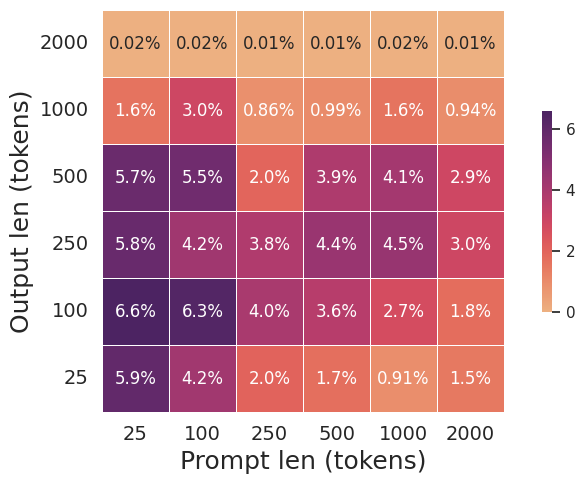

[[0.02 0.02 0.01 0.01 0.02 0.01]
 [1.61 2.96 0.86 0.99 1.59 0.94]
 [5.72 5.55 1.98 3.86 4.11 2.93]
 [5.75 4.25 3.81 4.41 4.47 2.95]
 [6.56 6.35 3.98 3.6  2.72 1.76]
 [5.93 4.18 2.02 1.72 0.91 1.46]]


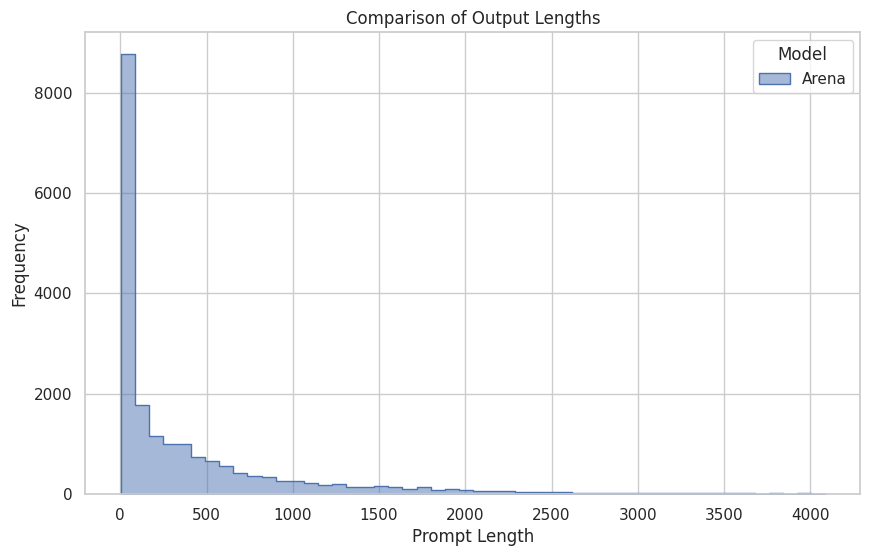

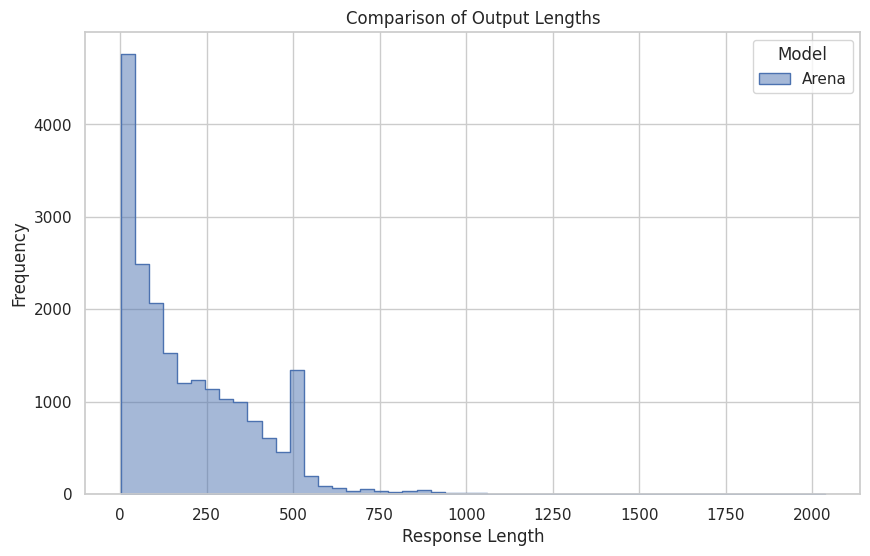

In [20]:
# Arena 1M Conversations
arena1m_dataset = get_dataset("lmsys/lmsys-chat-1m")
arena1m_token_dataset = get_token_dataset(arena1m_dataset)
arena1m_inlens, arena1m_outlens = get_chat_lens(arena1m_token_dataset)
print_distribution(arena1m_inlens, arena1m_outlens)
display_distribution(arena1m_inlens, arena1m_outlens)

# For input+output:
arena1m_distribution = lens_to_buckets(arena1m_inlens, arena1m_outlens)

# For input-only:
arena1m_inlen_distribution = inlens_to_buckets(arena1m_inlens)

## Solver Implementations

### Utils

In [21]:
from typing import List

# Convert max throughput profiling to a mapping from request size to load
def tputs_to_loads_2d(max_tputs: List[List[float]]):
    loads = []
    for i in range(len(max_tputs)):
        loads.append([])
        for j in range(len(max_tputs[0])):
            load = 1 / max_tputs[i][j]
            loads[-1].append(load)
    return loads

In [22]:
def display_experiment_results(results, solver_labels, ilp_result):
  df = pd.DataFrame(results)
  df.fillna(0, inplace=True)

  # Add the last column filled with zeros
  df['Savings'] = [str(round(((x["cost"] - ilp_result["cost"])/x["cost"]) * 100, 2)) + "%" for x in results]

  # Ensure the 'cost' column is second to last and 'LastColumn' is last, this step might need adjustment based on actual GPU types
  # Assuming we don't know all GPU types in advance, let's dynamically sort columns except for 'cost' and 'LastColumn'
  gpu_columns = [col for col in df.columns if col not in ['cost', 'Savings']]
  sorted_columns = gpu_columns + ['cost', 'Savings']
  df = df[sorted_columns]
  df.index = solver_labels

  # Display the table
  print(df)

### ILP

In [23]:
# Input+output solver

import pulp
from pulp import LpVariable, LpProblem, LpMinimize, LpInteger

def run_ILP_solver(workload_distribution, overall_rate, slice_factor, gpu_info, logs=False):
    # Multiply overall rate across distribution.
    request_rate_histogram = []
    for i in range(len(workload_distribution)):
        request_rate_histogram.append([])
        for j in range(len(workload_distribution[0])):
            request_rate_histogram[-1].append(workload_distribution[i][j] * overall_rate)

    # Conver the profiled max throughputs into mapping from request size to load
    for gpu in gpu_info:
        gpu_info[gpu]["loads"] = tputs_to_loads_2d(gpu_info[gpu]["tputs"])

    gpu_types = list(gpu_info.keys())
    cost_vector = [gpu_info[gpu]["cost"] for gpu in gpu_types]

    # Create slices, which is a single dimension.
    slices = []
    for i in range(len(request_rate_histogram)):
      for j in range(len(request_rate_histogram[i])):
        for _ in range(slice_factor):
            slices.append(request_rate_histogram[i][j] / slice_factor)
    
    # Create slice-to-load mapping, which is a single dimension.
    for gpu in gpu_types:
        slice_loads = []
        for i in range(len(gpu_info[gpu]["loads"])):
            for j in range(len(gpu_info[gpu]["loads"][i])):
                for _ in range(slice_factor):
                    slice_loads.append(gpu_info[gpu]["loads"][i][j])
        assert len(slices) == len(slice_loads)
        gpu_info[gpu]["slice_loads"] = slice_loads


    # Decision matrix value is binary. The slice is assigned to a GPU, or it isn't.
    matrix_rows = len(slices)
    matrix_cols = len(gpu_types)

    # Vector value is non-negative integer of how many of each GPU type are needed
    vector_length = matrix_cols

    decision_matrix = [[LpVariable(f"x_{i}_{j}", cat=LpInteger, lowBound=0, upBound=1) for j in range(matrix_cols)] for i in range(matrix_rows)]
    decision_vector = [LpVariable(f"y_{i}", cat=LpInteger, lowBound=0) for i in range(vector_length)]

    # Objective: minimize cost
    problem = LpProblem("GpuAllocation", LpMinimize)
    problem += pulp.lpSum([decision_vector[i] * cost_vector[i] for i in range(len(decision_vector))])

    # C1: Each row of decision matrix must sum to exactly 1 (ie, each slice assigned to one GPU)
    for i in range(len(decision_matrix)):
        problem += pulp.lpSum(decision_matrix[i]) == 1

    # C2: Load of column of decision matrix must fit in decision vector capacity
    for j in range(len(decision_matrix[0])):
        # j is idx of GPU type, i is slice
        problem += pulp.lpSum([decision_matrix[i][j] * gpu_info[gpu_types[j]]["slice_loads"][i] * slices[i] for i in range(len(decision_matrix))]) <= decision_vector[j]
        # problem += pulp.lpSum([decision_matrix[i][j] * norm_coefficients[j][i] * request_rate_histogram[i] for i in range(len(decision_matrix))]) <= decision_vector[j]

    # Solve the problem
    problem.solve(pulp.PULP_CBC_CMD(msg=0))

    # Print the results
    # print("Status:", pulp.LpStatus[problem.status])
    if logs:
        print(f'Decision Matrix:')
        for row in decision_matrix:
            print([var.value() for var in row])
        print(f'Decision Vector:')
        print(f'{[var.value() for var in decision_vector]}')

    if pulp.LpStatus[problem.status] != 'Optimal':
        return None
    
    solution_dict = {}
    for i in range(len(decision_vector)):
        solution_dict[gpu_types[i]] = decision_vector[i].value()

    total_cost = 0
    for gpu in solution_dict:
        total_cost += solution_dict[gpu] * gpu_info[gpu]["cost"]
    solution_dict["cost"] = total_cost
    
    return solution_dict


### Single-Accelerator Solver

In [24]:
import math

def run_single_accelerator_solver(workload_distribution, overall_rate, gpu_type, gpu_info):
  # Multiply overall rate across distribution.
  request_rate_histogram = []
  for i in range(len(workload_distribution)):
      request_rate_histogram.append([])
      for j in range(len(workload_distribution[0])):
          request_rate_histogram[-1].append(workload_distribution[i][j] * overall_rate)

  # Get the request size to load mapping for this specific GPU.
  loads = tputs_to_loads_2d(gpu_info[gpu_type]["tputs"])

  # Compute aggregate load.
  aggregate_load = 0
  for i in range(len(request_rate_histogram)):
     for j in range(len(request_rate_histogram[i])):
        aggregate_load += request_rate_histogram[i][j] * loads[i][j]
  
  num_gpus = math.ceil(aggregate_load)
  return { gpu_type : num_gpus, "cost" : num_gpus * gpu_info[gpu_type]["cost"]}

## Setting Creation
Choose the parameters of the experiment setting.

In [26]:
gpu_info_llama7b = {
  "L4" : {
      "cost": 0.7,
      "tputs": [
                  [25.14, 8.53, 2.34, 0.78, 0.22, 0.07],
                  [17.55, 4.86, 1.67, 0.62, 0.2, 0.06],
                  [6.75, 2.72, 1.06, 0.45, 0.17, 0.06],
                  [3.84, 1.64, 0.73, 0.34, 0.13, 0.05],
                  [2.07, 0.94, 0.42, 0.21, 0.09, 0.04],
                  [1.04, 0.5, 0.23, 0.12, 0.05, 0.02]
               ],
   },
   "A10G" : {
      "cost": 1.01,
      "tputs": [
                  [33.96,12.35,3.98,1.46,0.44,0.13],
                  [25.49,7.85,2.99,1.12,0.39,0.11],
                  [11.47,5.5,2.15,0.86,0.32,0.11],
                  [6.16,2.62,1.32,0.6,0.26,0.11],
                  [3.1,1.51,0.77,0.38,0.17,0.07],
                  [1.61,0.81,0.42,0.22,0.11,0.04]
               ],
   },
   "A100" : {
      "cost": 3.67,
      "tputs": [
                  [46.7,21.65,10.38,4.68,1.7,0.51],
                  [44.48,21.41,9.77,3.97,1.57,0.45],
                  [33.7,17.13,7.58,3.29,1.28,0.52],
                  [18.59,9.19,4.74,2.42,1.04,0.47],
                  [9.85,5.56,3.01,1.62,0.73,0.3],
                  [5.22,3.08,1.72,0.97,0.48,0.2],
                  [2.779621835, 1.932321632, 0.9867683833, 0.555555, 0.1742717633, 0.148405185],
                  [1.337126213, 0.65, 0.3615117588, 0.21, 0.1362550917, 0.08194139326],
                  [0.8446002998, 0.44, 0.2709054377, 0.1376928475, 0.0610163519, 0.03195268169],
                  [0.604766095, 0.4522369937, 0.2985055858],
               ],
   },
   "H100" : {
      "cost": 6.234,
      "tputs": [
                  [40.64087824, 19.54507829, 10.3999441, 5.099362587, 1.917021277, 0.6212185252],
                  [40.0276272, 18.60417258, 9.854607493, 3.767707006, 1.729453125, 0.585],
                  [33.46363944, 16.07364441, 7.693894679, 4.336818182, 1.706666667, 0.7511111111],
                  [22.37356769, 10.6828903, 5.503884298, 3.220522307, 1.594965035, 0.7206666667],
                  [12.69134615, 7.805287214, 4.115091145, 2.307945205, 1.168, 0.5217258883],
                  [7.160757835, 4.886714532, 2.534976225, 1.762233206, 0.851416041, 0.3778575129],
                  [4.405518537, 4.072455048, 2.247663041, 1.206886396, 0.3984329411, 0.3682428561],
                  [2.562388986, 1.427361626, 0.8391410771, 0.5194776914, 0.3413079555, 0.2092429981],
                  [1.763873906, 1.038761212, 0.6182088503, 0.3611895848, 0.1972894637, 0.1011775347],
                  [1.301854423, 1.186287414, 0.7623566292]
               ],
   }
}

[]

workload_distribution = arena1m_distribution

overall_rate = 4

slice_factor = 1

ilp_result = run_ILP_solver(workload_distribution=workload_distribution, overall_rate=overall_rate, slice_factor=slice_factor, gpu_info=gpu_info_llama7b, logs=False)
h100_result = run_single_accelerator_solver(workload_distribution=workload_distribution, overall_rate=overall_rate, gpu_type="H100", gpu_info=gpu_info_llama7b)
a100_result = run_single_accelerator_solver(workload_distribution=workload_distribution, overall_rate=overall_rate, gpu_type="A100", gpu_info=gpu_info_llama7b)
a10g_result = run_single_accelerator_solver(workload_distribution=workload_distribution, overall_rate=overall_rate, gpu_type="A10G", gpu_info=gpu_info_llama7b)
l4_result = run_single_accelerator_solver(workload_distribution=workload_distribution, overall_rate=overall_rate, gpu_type="L4", gpu_info=gpu_info_llama7b)

results = [ilp_result, h100_result, a100_result, a10g_result, l4_result]
solver_labels = ["ILP", "H100-only", "A100-only", "A10G-only", "L4-only"]
display_experiment_results(results, solver_labels, ilp_result)

IndexError: list index out of range

In [14]:
gpu_info_example = {
   "A10G" : {
      "cost": 1.01,
      "tputs": [[5, 1], 
                [10,5]],
   },
   "A100" : {
      "cost": 3.67,
      "tputs": [[20, 2],
                [50, 20]],
   }
}

workload_distribution = [[0.25, 0.5],
                         [0.25, 0.25]]

overall_rate = 16

slice_factor = 1

print(run_ILP_solver(workload_distribution=workload_distribution, overall_rate=overall_rate, slice_factor=slice_factor, gpu_info=gpu_info_example, logs=False))

{'A10G': 10.0, 'A100': 0.0, 'cost': 10.1}
